In [1]:
import os
import tensorflow as tf
import numpy as np
import cv2

from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow_datasets as tfds
from keras.datasets import fashion_mnist

tfds.disable_progress_bar()

from tensorflow.keras.models import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer,Lambda,InputLayer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

import cvnn.layers as complex_layers

import warnings
warnings.filterwarnings('ignore')

/Users/quytrungg/.pyenv/versions/3.10.12/envs/deep-learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
size = 56
BUFFER_SIZE = 50
BATCH_SIZE_PER_REPLICA = 8
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * 1

# Define the traning parameters
keep_training = False
learning_rate = 0.01
epochs = 4

# load the dataset
datasets, info = tfds.load(name='fashion_mnist', with_info=True, as_supervised=True, data_dir='./data')

fashion_mnist_train, fashion_mnist_test = datasets['train'], datasets['test']

num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

In [4]:
# datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True, data_dir='./data')

mnist_train, mnist_test = datasets['train'], datasets['test']

num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

In [5]:
# datasets, info = tfds.load(name='emnist', with_info=True, as_supervised=True, data_dir='./data')

emnist_train, emnist_test = datasets['train'], datasets['test']

num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

In [6]:
# datasets, info = tfds.load(name='kmnist', with_info=True, as_supervised=True, data_dir='./data')

kmnist_train, kmnist_test = datasets['train'], datasets['test']

num_train = info.splits['train'].num_examples
num_test = info.splits['test'].num_examples

### 1.Define phase object ( Preprocess the images with up-sampling )
1. Load image that serves as phase object  

2. Image is 28x28 pixels, and is padded to 200x200 pixels  with 0's  

3. Phase Image = exp(2$\pi$ i * Padded Image)

The digital image is encoded in phasor form, with an uniform amplitude and different phase angle.


In [7]:
def preprocess(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 10)   # convert the label to categorial, or one-hot coded
    
    up_sampling_size = int(1*size)
    padding_size = (size - up_sampling_size)//2
    image = tf.cast(image, tf.float32)
    # Step1: upsample the image to 56x56
    up_sampling_image = tf.image.resize(image,
                                        size=[up_sampling_size,up_sampling_size],
                                        method='nearest')
    up_sampling_image = up_sampling_image / 255.0
    # Step2: get the phase object
    phase_image = tf.math.exp(2*np.pi*1j*tf.cast(up_sampling_image,dtype=tf.complex64))
    # Step3: pad the phase object to 200x200 with 0s
    zero_padded_image = tf.pad(phase_image,
                                paddings=[[padding_size,padding_size],[padding_size,padding_size],[0,0]],
                                mode="CONSTANT",constant_values=0)
        
    return tf.cast(zero_padded_image, dtype=tf.complex64), label
    
train_dataset_fmnist = fashion_mnist_train.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset_fmnist = fashion_mnist_test.map(preprocess).batch(BATCH_SIZE,drop_remainder=True)

In [8]:
train_dataset_mnist = mnist_train.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset_mnist = mnist_test.map(preprocess).batch(BATCH_SIZE,drop_remainder=True)

train_dataset_kmnist = kmnist_train.map(preprocess).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset_kmnist = kmnist_test.map(preprocess).batch(BATCH_SIZE,drop_remainder=True)

#### Visualize the data

2023-07-13 19:35:54.435162: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


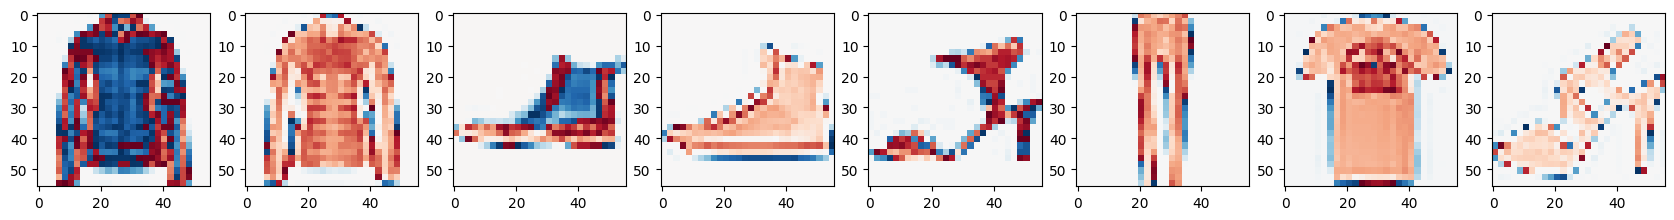

In [9]:
# plot the phase(angle) of the phase images
rows, cols = 1 ,8
fig = plt.figure(figsize=(21,8))
for images, labels in test_dataset_fmnist.take(1):
    for i in range(8):
        fig.add_subplot(rows,cols,i+1)
        image = np.angle(images[i].numpy()).squeeze()
        # print(np.min(np.abs(images[i].numpy()).squeeze())) # check the amplitude of the phase object
        plt.imshow(image,cmap='RdBu')

2023-07-13 19:35:55.991334: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


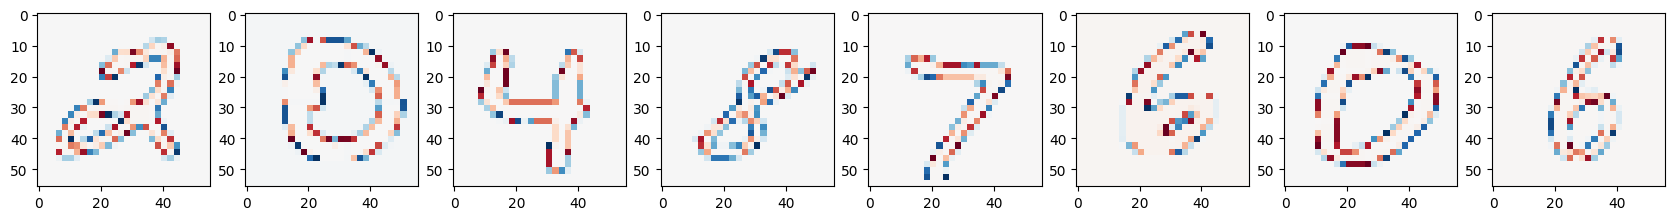

In [10]:
# plot the phase(angle) of the phase images
rows, cols = 1 ,8
fig = plt.figure(figsize=(21,8))
for images, labels in test_dataset_kmnist.take(1):
    for i in range(8):
        fig.add_subplot(rows,cols,i+1)
        image = np.angle(images[i].numpy()).squeeze()
        # print(np.min(np.abs(images[i].numpy()).squeeze())) # check the amplitude of the phase object
        plt.imshow(image,cmap='RdBu')

2023-07-13 19:44:56.489139: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


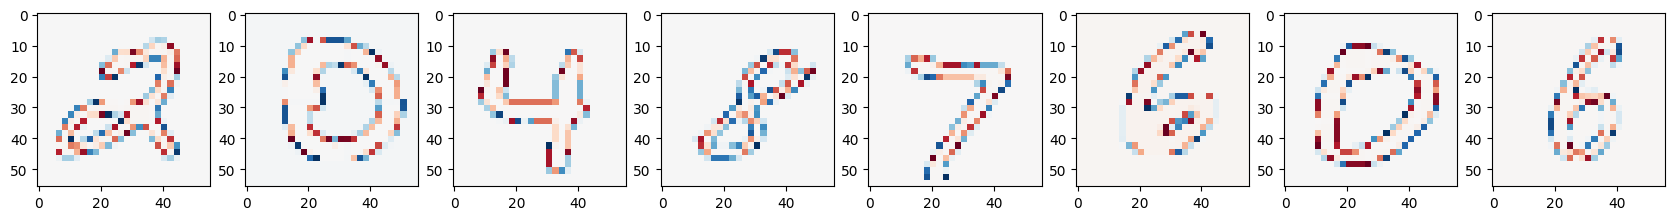

In [34]:
# plot the phase(angle) of the phase images
rows, cols = 1 ,8
fig = plt.figure(figsize=(21,8))
for images, labels in test_dataset_mnist.take(1):
    for i in range(8):
        fig.add_subplot(rows,cols,i+1)
        image = np.angle(images[i].numpy()).squeeze()
        # print(np.min(np.abs(images[i].numpy()).squeeze())) # check the amplitude of the phase object
        plt.imshow(image,cmap='RdBu')

### 2.Build the Diffraction layer using Angular Spectrum method

### Angular Spectrum Propagation
$$U_1(x,y) =\mathcal{F}^{-1}[\mathcal{F} U_0(x,y)\mathcal{F}h(x,y)]$$

$$U_1(x,y) =\mathcal{F}^{-1}[\mathcal{F} U_0(x,y) H(f_x,f_y)]$$


This can be described using Fourier transforms.The first Fourier transform decomposes the initial field into plane waves. To propagate the plane waves, we multiply each wave by a complex phase factor, and then we take the inverse Fourier transform to add all the propagated plane waves back together.

To implement Angular spectrum propagation, the Fouier transform of the initial field is first multiplied with the phase factor $$H=e^{ik_zz}$$, where $k_z$is a function of the spatial frequencies $$k_z=\sqrt{k^2-k_x^2-k_y}$$where $$  k = \frac{2\pi}{\lambda}$$ and $k_x$ and $k_y$ are related to the spatial frequencies $f_x$ and $f_y$ by a factor of $2\pi$ $$k_{x,y} = 2\pi f_{x,y}$$

Hence the complex exponential can be written in terms of the Fourier coordinates $f_x$ and $f_y$, that is 

$$H=e^{ik_zz},k_z = 2\pi \sqrt{\frac{1}{\lambda}-f_x-f_y}$$

Descretized spatial freqnency $f_x = k*\Delta f = \frac{k}{N \Delta x}$  
Interval between the spatial frequencies $\Delta f = \frac{1}{N \Delta x}=\frac{1}{L}$,where $L$ denotes the field of view in object space

In [12]:
class Diffraction_Layer(Layer):
    def __init__(self, units =200):
        '''Initialize the diffraction layer attributes'''
        super(Diffraction_Layer, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        # self.L = 0.08              # source and observation plane side length, field of view
        self.dx = 100e-6
        self.lam = 0.75e-3           # wavelength of the optical wave: 0.75 mm
        self.z = 3e-2                # distance of propagation(the distance bewteen two layers)
   
    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        phase_init = tf.random_normal_initializer()
        self.phase = tf.Variable(name= "phase",
                                initial_value=phase_init(shape=(self.units,self.units), dtype='float32'),
                                trainable=True,
                                constraint=lambda t: tf.clip_by_value(t, 0, 2*np.pi))
        # To help with the 3D-printing and fabrication of the D2NN design, 
        # a sigmoid function was used to constrain the phase value of each neuron
    @tf.function
    def call(self, inputs):
        '''Define the computation'''
        def angular_spectrum_propagator(E, z = self.z, lam = self.lam):
            # compute angular spectrum
            fft_c = tf.signal.fft2d(E)
            c = tf.signal.fftshift(fft_c)

            fx = np.fft.fftshift(np.fft.fftfreq(self.Nx, d = self.dx))
            fxx, fyy = np.meshgrid(fx, fx)
            argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

           #Calculate the propagating and the evanescent (complex) modes
            tmp = np.sqrt(np.abs(argument))
            kz = np.where(argument >= 0, tmp, 1j*tmp)

            # propagate the angular spectrum a distance z
            E = tf.signal.ifft2d(tf.signal.ifftshift(c * np.exp(1j * kz * z)))
            return E
        return tf.multiply(angular_spectrum_propagator(inputs),tf.math.exp(1j*tf.cast(self.phase,dtype=tf.complex64)))

#### Notice
For ___tf.cast()___: In case of casting from real types to complex types(complex64), the imaginary part of the returned value is set to 0.    

In [13]:
class Propogation(Layer):
    def __init__(self, units =200):
        '''Initialize the diffraction layer attributes'''
        super(Propogation, self).__init__()
        self.units = units
        self.Nx = units              # Nx is the dimension of the grid
        self.dx = 100e-6
        self.lam = 0.75e-3            # wavelength of the opticalwave
        self.z = 1e-2                # distance of propagation(the distance bewteen last layer and the detector)
        
    @tf.function
    def call(self, inputs):
        '''Define the computation'''
        def angular_spectrum_propagator(E, z = self.z, lam = self.lam):
            # compute angular spectrum
            fft_c = tf.signal.fft2d(E)
            c = tf.signal.fftshift(fft_c)

            fx = np.fft.fftshift(np.fft.fftfreq(self.Nx, d = self.dx))
            fxx, fyy = np.meshgrid(fx, fx)
            argument = (2 * np.pi)**2 * ((1. / lam) ** 2 - fxx ** 2 - fyy ** 2)

           #Calculate the propagating and the evanescent (complex) modes
            tmp = np.sqrt(np.abs(argument))
            kz = np.where(argument >= 0, tmp, 1j*tmp)

            # propagate the angular spectrum a distance z
            E = tf.signal.ifft2d(tf.signal.ifftshift(c * np.exp(1j * kz * z))) # phase是加还是减
            return E
        return angular_spectrum_propagator(inputs)
        

In [14]:
class Detector(Layer):
    def __init__(self, units=200):
        '''Initialize the instance attributes'''
        super(Detector, self).__init__()
        self.units = units
    
    @tf.function
    def call(self, inputs):
        ''' Converts output to one hot form
        Applies softmax'''
        
        def rang(arr,shape,size=size,base = 500):
            x0 = shape[0] * size // base
            y0 = shape[2] * size // base
            delta = (shape[1]-shape[0])* size // base
            return arr[x0:x0+delta,y0:y0+delta]
        
        def reduce_mean(tf_):
            return tf.reduce_mean(tf_)
        
        def _ten_regions(a):
            return tf.map_fn(reduce_mean,tf.convert_to_tensor([
                rang(a,(120,170,120,170)),
                rang(a,(120,170,240,290)),
                rang(a,(120,170,360,410)),
                rang(a,(220,270,120,170)),
                rang(a,(220,270,200,250)),
                rang(a,(220,270,280,330)),
                rang(a,(220,270,360,410)),
                rang(a,(320,370,120,170)),
                rang(a,(320,370,240,290)),
                rang(a,(320,370,360,410))
            ]))
        
        def ten_regions(logits):
            return tf.map_fn(_ten_regions,tf.abs(logits),dtype=tf.float32)

        return tf.square(ten_regions(tf.abs(inputs))) # logits_abs

In [15]:
def loss_function(y_label,logits_abs):
    return tf.reduce_mean(tf.square(logits_abs-y_label))

In [35]:
train_dataset_fmnist =  list(train_dataset_fmnist)
train_dataset_kmnist = list(train_dataset_kmnist)
train_dataset_mnist = list(train_dataset_mnist)

train_dataset_fmnist = [ i[0] for i in train_dataset_fmnist] , [ i[1] for i in train_dataset_fmnist]
train_dataset_kmnist = [ i[0] for i in train_dataset_kmnist] , [ i[1] for i in train_dataset_kmnist]
train_dataset_mnist = [ i[0] for i in train_dataset_mnist] , [ i[1] for i in train_dataset_mnist]

In [31]:
def get_D2NN_model():
    inputs = complex_layers.complex_input(shape=(size,size))
    h1 = Diffraction_Layer(size)(inputs)
    h2 = Diffraction_Layer(size)(h1)
    h3 = Diffraction_Layer(size)(h2)
    h4 = Diffraction_Layer(size)(h3)
    propogation = Propogation(size)(h4)
    out = Detector()(propogation)
    return tf.keras.Model(inputs, out)

def get_D2NN_model_detect(model):
    inputs = complex_layers.complex_input(shape=(size,size))
    h1 = Diffraction_Layer(size)(inputs)
    h2 = Diffraction_Layer(size)(h1)
    h3 = Diffraction_Layer(size)(h2)
    h4 = Diffraction_Layer(size)(h3)
    propogation = Propogation(size)(h4)
    M =  tf.keras.Model(inputs, propogation)
    for i in range(len(M.layers)):
        M.layers[i].set_weights( model.layers[i].get_weights() )

    return M


D2NN = get_D2NN_model()

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

D2NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
             loss=loss_function,
             metrics=['accuracy'])

# D2NN.summary()
# plot_model(D2NN, show_shapes=True, show_layer_names=True, to_file='D2NN-model.png')

In [32]:
D2NN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (ComplexInput)      [(None, 56, 56)]          0         
                                                                 
 diffraction__layer_12 (Dif  (None, 56, 56)            3136      
 fraction_Layer)                                                 
                                                                 
 diffraction__layer_13 (Dif  (None, 56, 56)            3136      
 fraction_Layer)                                                 
                                                                 
 diffraction__layer_14 (Dif  (None, 56, 56)            3136      
 fraction_Layer)                                                 
                                                                 
 diffraction__layer_15 (Dif  (None, 56, 56)            3136      
 fraction_Layer)                                           

In [18]:
def custom_training(model:tf.keras.models,fmnist,kmnist,mnist,epochs =1,batch =1):

    if epochs < 1:
        epochs = 1
    if batch < 1 :
        batch = 1

    # clone
    model_1 = get_D2NN_model()
    model_2 = get_D2NN_model()
    model_3 = get_D2NN_model()

    model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=loss_function,
            metrics=['accuracy'])
        
    model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=loss_function,
        metrics=['accuracy'])
    
    model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=loss_function,
        metrics=['accuracy'])

    
    num_train = min([len(train_dataset_mnist[0]), len(train_dataset_kmnist[0]) , len(train_dataset_fmnist[0])])
    for ep in range(epochs):
        print('epochs: ',ep+1,'/',epochs)

        for i in range(int(num_train/batch)):

            if i%10 ==0 :
                print('iterator:' , i)

            model_1.set_weights(model.get_weights())
            model_2.set_weights(model.get_weights())
            model_3.set_weights(model.get_weights())

            # rotate
            model_2.layers[-3].set_weights([np.rot90(*model_2.layers[-3].get_weights())])
            model_3.layers[-4].set_weights([np.rot90(*model_3.layers[-4].get_weights())])
            
            # train


            start = i*batch
            end = (i+1)*batch
            
            model_1.fit(x=np.concatenate(mnist[0][start:end]),y = np.concatenate(mnist[1][start:end]),batch_size=8,verbose=0)
            model_2.fit(x=np.concatenate(kmnist[0][start:end]),y = np.concatenate(kmnist[1][start:end]),batch_size=8,verbose=0)
            model_3.fit(x=np.concatenate(fmnist[0][start:end]),y = np.concatenate(fmnist[1][start:end]),batch_size=8,verbose=0)
            
            
            model_2.layers[-3].set_weights([np.rot90(*model_2.layers[-3].get_weights(),3)])
            model_3.layers[-4].set_weights([np.rot90(*model_3.layers[-4].get_weights(),3)])
            
            

            for lay in range(1,5):
                model.layers[lay].set_weights([(model_1.layers[lay].get_weights()[0]+model_2.layers[lay].get_weights()[0] +model_3.layers[lay].get_weights()[0])/3])



In [19]:
def custom_training_2(model:tf.keras.models,fmnist,kmnist,mnist,epochs =1,batch =1):

    if epochs < 1:
        epochs = 1
    if batch < 1 :
        batch = 1
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=loss_function,
            metrics=['accuracy'])
    
    mod = [0,1,2]

    num_train = min([len(train_dataset_mnist[0]), len(train_dataset_kmnist[0]) , len(train_dataset_fmnist[0])])
    for ep in range(epochs):
        print('epochs: ',ep+1,'/',epochs)

        for i in range(int(num_train/batch)):

            if i%10 ==0 :
                print('iterator:' , i)

            np.random.shuffle(mod)
            
            start = i*batch
            end = (i+1)*batch

            for mode in mod:
                if mode == 0:
                    model.fit(x=np.concatenate(mnist[0][start:end]),y = np.concatenate(mnist[1][start:end]),batch_size=8,verbose=0)
                elif mode == 1:
                    model.layers[-3].set_weights([np.rot90(*model.layers[-3].get_weights())])
                    model.fit(x=np.concatenate(kmnist[0][start:end]),y = np.concatenate(kmnist[1][start:end]),batch_size=8,verbose=0)
                    model.layers[-3].set_weights([np.rot90(*model.layers[-3].get_weights(),3)])
                elif mode == 2:
                    model.layers[-4].set_weights([np.rot90(*model.layers[-4].get_weights())])
                    model.fit(x=np.concatenate(fmnist[0][start:end]),y = np.concatenate(fmnist[1][start:end]),batch_size=8,verbose=0)
                    model.layers[-4].set_weights([np.rot90(*model.layers[-4].get_weights(),3)])


In [20]:
D2NN = get_D2NN_model()

In [ ]:
custom_training(D2NN,
                fmnist=train_dataset_fmnist,
                kmnist=train_dataset_kmnist,
                mnist= train_dataset_mnist,
                epochs=4,batch=2)

In [ ]:
D2NN.save('final')

INFO:tensorflow:Assets written to: final\assets


INFO:tensorflow:Assets written to: final\assets


In [21]:
RONN = tf.keras.models.load_model("final")
RONN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
            loss=loss_function,
            metrics=['accuracy'])

### 3. Extracting weights from model
- Neurons’ phase values were converted into a relative height map (Δ𝑧=𝜆$\phi$/2𝜋Δ𝑛)    
  ,where Δ𝑛 is the refractive index difference between the 3D printing material (VeroBlackPlus RGD875) and air
- save the height map to a numpy file

In [22]:
#D2NN.load_weights('./training_results/D2NN_phase_only')
# print(D2NN.layers)
# print(D2NN.layers[1].weights)
# print(D2NN.layers[5].get_weights()) # get the numpy arrays for the parameters of the layer
# print(D2NN.get_layer('diffraction__layer_4').phase)

# Extract all the weights from the model
weights = []
# D2NN 中的 diffraction layer 从第二层开始，第一层是 input layer
for l in range(1,2+1):
    weights.append(np.squeeze(D2NN.layers[l].get_weights())) 
    
# Map the weights into range [0, 2*pi]
for l in range(0,2):
    for i in range(0,size):
        for j in range(0,size):
            while (weights[l][i][j] < 0):
                    weights[l][i][j] += 2*np.pi
            while(weights[l][i][j] > 2*np.pi):
                weights[l][i][j] -= 2*np.pi
print("The max value in wights is: " + str(np.max(weights)))
print("The mim value in wights is: " + str(np.min(weights)))

The max value in wights is: 6.2831044
The mim value in wights is: 3.1506064e-05


In [23]:
# Convert the weights to height map
lam = 0.75e-3

# VeroBlackPlus RGD875, refractive index: 1.7227
# SiO2 (Glass) - Palik, Refractive Index: 1.47012
material_refractive_index = 1.7227
air_refractive_index = 1.0003

delta_n = material_refractive_index - air_refractive_index

height_map = (lam*np.array(weights)) / (2*np.pi*delta_n)         

# Check the shape and save it to np file
print("The shape of the height map for all layers:",end=' ')
print(np.shape(np.array(height_map)))
print("Max and min value in height_map are: " + str(np.max(height_map)) + ", "+ str(np.min(height_map))+"\n")

np.save('height_map.npy',np.array(height_map))
print("height_map.npy has saved successfully")

The shape of the height map for all layers: (2, 56, 56)
Max and min value in height_map are: 0.0010381927, 5.205924e-09

height_map.npy has saved successfully


In [24]:
# get the height map for the filter
test_dataset = fashion_mnist_test.map(preprocess).batch(BATCH_SIZE)
for images, labels in test_dataset.take(1):
    images = tfds.as_numpy(images)
    for _ in range(1):
        image_phase = np.angle(images[3]).squeeze()
        for i in range(0,size):
            for j in range(0,size):
                while (image_phase[i][j] < 0):
                    image_phase[i][j] += 2*np.pi
                while(image_phase[i][j] > 2*np.pi):
                    image_phase[i][j] -= 2*np.pi
        # print(np.shape(image_phase))
        
        filter_height_map = (lam*np.array(image_phase)) / (2*np.pi*delta_n)
        np.save('filter_height_map.npy',np.array(filter_height_map))
        print("The shape of the filter height map for all layers:",end=' ')
        print(np.shape(np.array(filter_height_map)))
        print("Max and min value in height_map are: " + str(np.max(filter_height_map)) + ", "+ str(np.min(filter_height_map))+"\n")
        print("filter_height_map.npy has saved successfully")

The shape of the filter height map for all layers: (56, 56)
Max and min value in height_map are: 0.0010341346, 0.0

filter_height_map.npy has saved successfully


2023-07-13 19:37:21.234845: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### 4.Evaluation

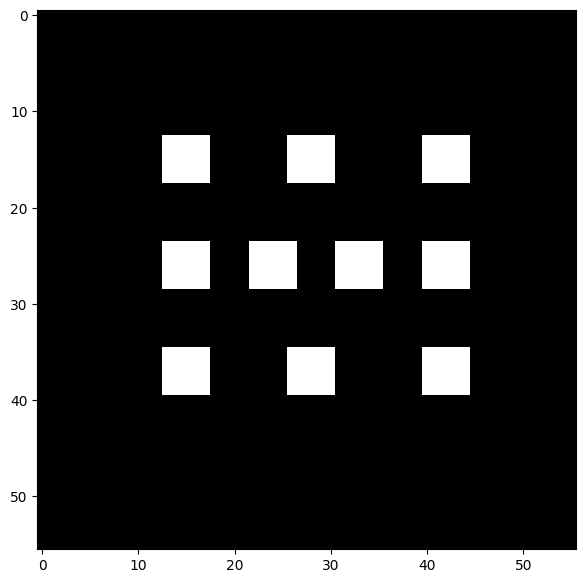

In [25]:
"""Plot the region of the ten detectors"""
detector_plane = np.zeros([size,size])

ten_detector_regions = [[120,170,120,170],
                        [120,170,240,290],
                        [120,170,360,410],
                        [220,270,120,170],
                        [220,270,200,250],
                        [220,270,280,330],
                        [220,270,360,410],
                        [320,370,120,170],
                        [320,370,240,290],
                        [320,370,360,410]] 

def get_range(shape,size=size,base = 500):
            x0 = shape[0] * size // base
            y0 = shape[2] * size // base
            delta = (shape[1]-shape[0])* size // base
            x1 = x0+delta
            y1 = y0+delta
            return x0,x1,y0,y1

for i in range(0,10):
    x0,x1,y0,y1 = get_range(ten_detector_regions[i])
    # print([x0,x1,y0,y1])
    detector_plane[x0:x1,y0:y1] = 1

# plot the detector region
rows, cols = 1 ,1
fig = plt.figure(figsize=(7,7))
plt.imshow(detector_plane,cmap='gray')

---

In [26]:
RONN = tf.keras.models.load_model('final')
RONN_nodetector = get_D2NN_model_detect(RONN)

In [27]:
def plot_phase(complex_arr):

    phase_image = complex_arr
    rows, cols = 1 ,2
    fig = plt.figure(figsize=(12,5))
    
    temp = np.absolute(phase_image)
    
    for i in range(detector_plane.shape[0]):
        for j in range(detector_plane.shape[1]):
            if detector_plane[i][j] == 0:
                temp[i][j] = 0
    
    plt.imshow(temp)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.07729536, 0.165096  , 0.09674882, 0.24200736, 0.06276488,
        0.10040962, 0.10620556, 0.06922168, 0.13607323, 0.08839674]],
      dtype=float32)>

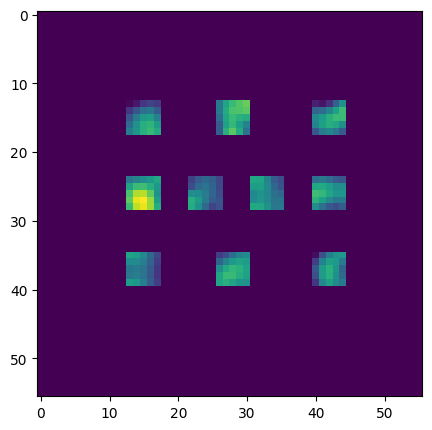

In [28]:
complex_arr = RONN_nodetector(train_dataset_mnist[0][2][0][None,:])[0]
plot_phase(complex_arr)
RONN(train_dataset_mnist[0][2][0][None,:])

------

In [29]:
RONN_nodetector.layers[-2].set_weights([np.rot90(*RONN_nodetector.layers[-2].get_weights())])
RONN.layers[-3].set_weights([np.rot90(*RONN.layers[-3].get_weights())])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.05740933, 0.1190253 , 0.11045122, 0.04178251, 0.07352608,
        0.19299227, 0.06051059, 0.09926828, 0.13016076, 0.08272669]],
      dtype=float32)>

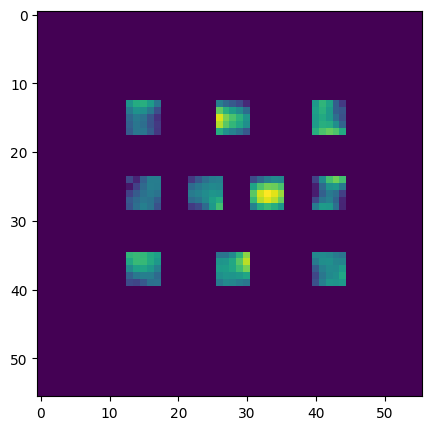

In [30]:
complex_arr = RONN_nodetector(train_dataset_kmnist[0][2][0][None,:])[0]
plot_phase(complex_arr)
RONN(train_dataset_kmnist[0][2][0][None,:])